# Registratrion Fraud

Registration fraud occurs when a bad actor attempts to create an account on a service using illegitimately attained personal details.

The challenge with detecting such fraud is that those accounts would be entirely new to the service. As new accounts, there would be no baseline data available to the service to be able to distinguish between what's typical and atypical for a given user.

The only viable option to detecting registration fraud is to examine _across_ users to seek out signals that could help distinguish illegitimate users.

__In this demonstration, we'll show how key press data collected through Moonsense can be used to identify patterns related to registration fraud by systematically examining behaviors across users.__ The scope of the current work covers data collection, data transformation, and preliminary data analysis. The findings at this phase can facilitate more sophisticated analysis and modeling later on.

This demonstration relies primarily on Python tooling, and utilizes methods commonly leveraged by data scientists. 

The presented code can be re-used to interact with Moonsense-sourced data.

# Literature

For this iteration of analysis, we'll focus mainly on __keystroke dynamics__, which refers to the cadence at which users press keys.

There is a healthy amount of academic literature that focuses on keystroke dynamics for the purpose of identifying fraud.

In a paper by Kevin Killourhy and Roy Maxion, [Comparing Anomaly-Detection Algorithms for Keystroke Dynamics](https://www.cs.cmu.edu/~maxion/pubs/KillourhyMaxion09.pdf), the authors compared a range of classification methods to distinguish legitimate from impostor users based solely on keystroke dynamics.

In another paper by John Manaco, [Robust Keystroke Biometric Anomaly Detection](https://arxiv.org/abs/1606.09075), the author assesses a range of anomaly detection systems based on keystroke dynamics and arrives at findings for their varying levels of efficacy.

In yet another paper by Junhong Kim, haedong Kim, and Pilsung Kang, [Keystroke Dynamics-Based User Authentication Using Freely Typed Text Based on User-Adaptive Feature Extraction and Novelty Detection](https://www.sciencedirect.com/science/article/abs/pii/S1568494617305847), the authors examine sequences of keys based on digraphs to discern users' distinct typing behaviors. 

These papers represent a small selection of a wide range of literature that highlight the viability of keystroke dynamics for authentication.



# Demo Design

For the purpose of this demonstration, we asked a set of users to engage with a Moonsense demo environment.

One of the sections of the demo environment includes a registration section.

The bottom left of the page includes a `Client Session Group` ID, which is a unique identifer for the given interaction.

The bottom left of the page reflects the version of the [web SDK](https://github.com/moonsense/moonsense-web-sdk) that has been deployed.

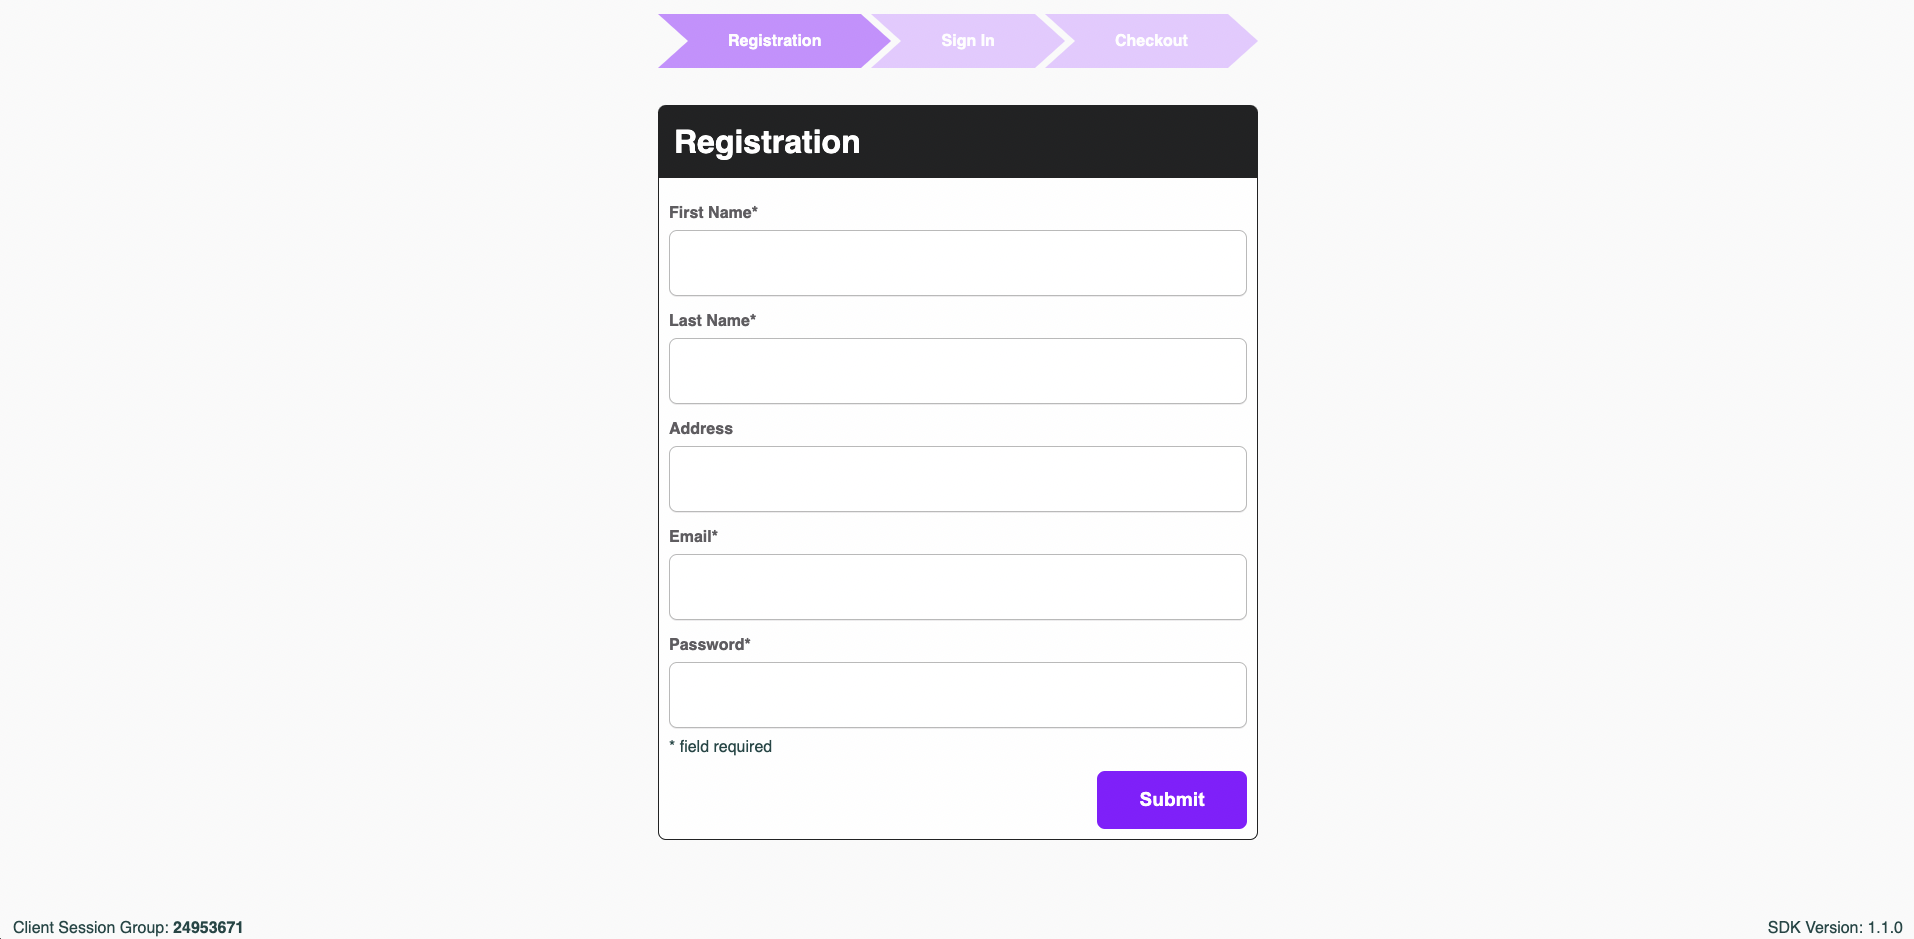

In this demo, we created a synthetic, balanced dataset. 

Each user was asked to input their own legitimate details a set number of times. Presumably, the users would be familiar with their own details (i.e., names, addresses, email), and would demonstrate a degree of fluidity with inputting those details. This set of inputs we refer to as `legitimate` – they're as if a legitimate user had registered.

Each user was also also asked to input an entirely made up set of details that they would _not_ be familiar with. The users would presumably be unpracticed and stilted with inputting these details. These registration iterations would be regarded as `illegitimate`.

We asked the users to record the `Client Session Group` ID as they walked through the demo environment. This effectively enables us to tag the data generated by Moonsense as `legitimate` or `illegitimate` – a binary data structure – which enables a wide range of analysis and supervised learning methods to be applied.

Below is a snippet of some synthetic data we asked our users to input, followed by the `Client Session Group` ID that the user input.

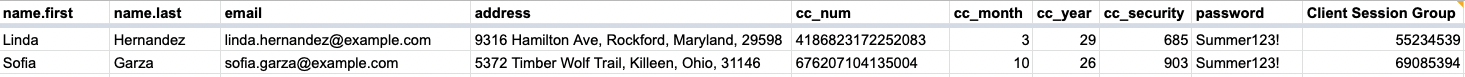

Once the input exercise was completed, we had a dataset made up of equal repetititions of `legitimate` and `illegitimate` repetitions.

To minimize environmental variabilty, we asked our users to only input details using a computer rather than with mobile devices.

# Language
Before we go further, it's worth taking a moment to go over some essential bits of Moonsense vocabulary.

* `User journey` – a discrete interaction between a user and a service running Moonsense.
* `ID` - unique identifier for a given user journey. The identifier can be a `uuid` or some other numerical-form ID, such as an eight-digit `Client Session Group` ID.
* `Session` - a time-bound period of interaction with the Moonsense collector. A single user journey, uniquely identified by an `ID` can have multiple instances of `Session`.
* `bundle` - a record of data collected by Moonsense, structured as a valid .json record. Each bundle covers a fixed duration of data. The longer that data that gets collected, the more bundles there are. A single `Session` can have multiple bundles.
* `raw_sealed_bundle.json` - a single file that contains all the bundle data for a single user journey during a given session. Different user journeys can have `raw_sealed_bundle.json` files of varying lengths.

# Setup
Before we proceed, we'll load a number of Python packages.

In [70]:
import pandas as pd # useful for data manipulation
import numpy as np # useful for numerical interaction
import json # interact with .json files
import os # interact with the local operating system
import glob # enumerate files and directory structures
import csv # interact with .csv files
import seaborn as sns # visualization tooling
import matplotlib.pyplot as plt # visualization tooling

In [2]:
# suppress verbose warnings
import warnings
warnings.filterwarnings('ignore')

# Functions

Below are a collection of simple and explicit functions that facilitate interactions with the Moonsense data in this demo.

In [3]:
def get_raw_sealed_bundle_paths(data_path):
    """
    Given a top-level data path, this enumerates all the complete paths for the various raw_sealed_bundles.
    """
    total_path = data_path + "/**/raw_sealed_bundles.json"
    raw_sealed_bundles_paths = glob.glob(total_path, recursive=True)
    
    return raw_sealed_bundles_paths

In [17]:
def extract_gid(raw_sealed_bundles_path):
    """
    Based on the path, pull out the Client Session Group ID
    This works because the Client Session Group ID is part of the directory structure
    """
    gid = raw_sealed_bundles_path.split(os.sep)[3]
    
    return gid

In [18]:
def extract_sessionid(raw_sealed_bundles_path):
    """
    Based on the path, pull out the Session ID
    This works because the Session ID is part of the directory structure
    """
    sessionid = raw_sealed_bundles_path.split(os.sep)[4]
    
    return sessionid

In [6]:
def single_session(raw_sealed_bundles_path):
    """
    For each session, generate a two-dimensional dataframe with details specific to the 'key_press_data' collected.
    """

    gid = extract_gid(raw_sealed_bundles_path)
    
    json_list = []
    with open(raw_sealed_bundles_path, 'r') as f:
        for json_record in f:
            record_dict = json.loads(json_record)

            if "key_press_data" in record_dict['bundle']:
                json_list.append(record_dict['bundle']['key_press_data'])  
    
    df_agg = pd.DataFrame()
    
    for i in range(len(json_list)):
        df = pd.json_normalize(json_list[i])
        df_agg = df_agg.append(df)
    
    df_agg['gid'] = gid
    
    return df_agg

In [7]:
def multi_session(data_path):
    """
    Given a top level data path, generate a consolidated dataframe of all key_press_data.
    """
    
    raw_paths = get_raw_sealed_bundle_paths(data_path)
    
    df_multi = pd.DataFrame()
    
    for path in raw_paths:
        df_single = single_session(path)
        df_multi = df_multi.append(df_single)
    
    return df_multi

# Data

## Authentication

__For this exercise, we'll focus primarily on key press data__, though there is plenty more Moonsense-sourced data to pick from.

To access the data en masse, first we'll have generate a secret authentication token through the Moonsense console by navigating to `Apps`, selecting the appropriate App, and creating a token.

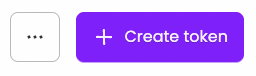

Once the token creation process is completed, a secret token and a public token will appear.


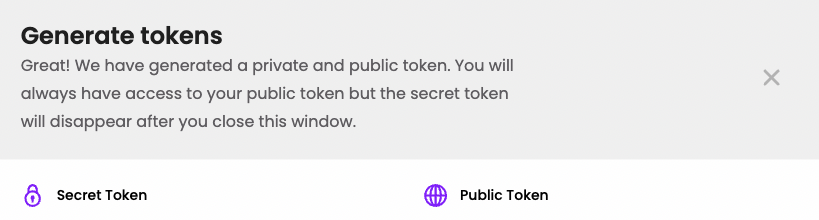

We recommend saving the tokens and then assigning the secret token to an environment variable.  The default token name that the Moonsense Python SDK searches for is called `MOONSENSE_SECRET_TOKEN`.

## Download

For convenience, we've provided a script `utils/download.py` that can programmatically download Moonsense data en masse.

It accepts three optional arguments, including:
* A start date
* An end date
* A .csv file with a `group_id` that will filter the returned data to only include data with matching `Client Session Group` IDs.

In our case, we executed the script with the following:

```bash
python3 utils/download.py --since 2022-08-03 --until 2022-08-06 --filter_by inputs/filtered_list.csv
```

Where `inputs/filtered_list.csv` is a .csv containg `Client Session Group` IDs.


Note that the script seeks out a `MOONSENSE_SECRET_TOKEN` environment variable for authentication purposes.

Successful execution of the script downloads a mass of data:

```bash
> tree data -l 3

data
├── 2022-08-04
│   └── 33643170
│       ├── eHZQczKU7Kcj57g586kZda
│       │   ├── metadata.json
│       │   └── raw_sealed_bundles.json
│       └── mdHAbnakubRW5NMdbii8g8
│           ├── metadata.json
│           └── raw_sealed_bundles.json
└── 2022-08-05
    ├── 06136989
    │   ├── B8qd5qLumW6c4NQs9zj9xY
    │   │   ├── metadata.json
    │   │   └── raw_sealed_bundles.json
    │   ├── NUtMTn28SqVZSxbt2zFopN
    │   │   ├── metadata.json
    │   │   └── raw_sealed_bundles.json
    │   ├── QJEknkpX6HhUCj2rq7eWp7
    │   │   ├── metadata.json
    │   │   └── raw_sealed_bundles.json

...
```
The path structure is of the form: `./data/<date>/<Client Session Group>/<session>/*.json`

## Reshape data

The data in its raw form is rich, but it still needs to be reshaped for any given purpose.

In our case, our aim is to focus on keystroke dynamics, which is contained in `key_press_data` within the raw data. We are especially interested in the timing patterns of key presses. `key_press_data` appears across numerous `Session` records spread across different `raw_sealed_bundle.json` files.

Our goal is to generate a [tidy](https://vita.had.co.nz/papers/tidy-data.pdf), flat dataframe that includes all available data related to the key presses – the timings, the time differences from key press event to another, the keys themselves, the user behind the keys, and more.

In [19]:
# specify the path to the data
top_data_path = "../data/"

In [20]:
raw_sealed_bundles = get_raw_sealed_bundle_paths(top_data_path)

In [21]:
# pick an arbitrary index to test out
dat_index = 40

In [22]:
# let's take a look at what that path looks like
raw_sealed_bundles[dat_index]

'../data/2022-08-05/32848205/mQuKxnyn5JH7cmGvjSDT48/raw_sealed_bundles.json'

In [23]:
# we'll test out one of our functions
extract_gid(raw_sealed_bundles[dat_index])

'32848205'

In [24]:
# and then test out another
extract_sessionid(raw_sealed_bundles[dat_index])

'mQuKxnyn5JH7cmGvjSDT48'

In [25]:
# then extract the key_press_data from that session
single_session(raw_sealed_bundles[dat_index]).head(10)

,determined_at,type,masked_key,target.target_id,target.target_type,special_key,gid
0,70336,KEY_DOWN,110.0,2333f01a-315c-4b47-9692-b23eb27a9961,text,NaN,32848205
1,70408,KEY_UP,110.0,2333f01a-315c-4b47-9692-b23eb27a9961,text,NaN,32848205
2,70536,KEY_DOWN,578.0,2333f01a-315c-4b47-9692-b23eb27a9961,text,NaN,32848205
3,70616,KEY_UP,578.0,2333f01a-315c-4b47-9692-b23eb27a9961,text,NaN,32848205
0,71160,KEY_DOWN,668.0,2333f01a-315c-4b47-9692-b23eb27a9961,text,NaN,32848205
1,71264,KEY_UP,668.0,2333f01a-315c-4b47-9692-b23eb27a9961,text,NaN,32848205
2,71560,KEY_DOWN,84.0,2333f01a-315c-4b47-9692-b23eb27a9961,text,NaN,32848205
3,71688,KEY_UP,84.0,2333f01a-315c-4b47-9692-b23eb27a9961,text,NaN,32848205
0,72088,KEY_DOWN,110.0,2333f01a-315c-4b47-9692-b23eb27a9961,text,NaN,32848205
1,72200,KEY_UP,110.0,2333f01a-315c-4b47-9692-b23eb27a9961,text,NaN,32848205


Great! Now we have a sense of what data gets collected on a per-session basis.

Next, we'll want to traverse the directory structure and pull out the same key press data across the various sessions and Client Group Sessions.

In [26]:
%%time

all_key_press_data = multi_session(top_data_path)

CPU times: user 18.3 s, sys: 692 ms, total: 19 s
Wall time: 19.2 s


For a quick previous of the data, we can take a glance at the top set of records and the bottom set of records:

In [27]:
all_key_press_data.head()

,determined_at,type,special_key,meta_key,target.target_id,masked_key,gid,target.target_type,shift_key,control_key
0,6411,KEY_DOWN,Meta,True,fbb0cff7-9c07-4043-bebd-eb922021bf0c,NaN,33643170,NaN,NaN,NaN
1,6522,KEY_DOWN,NaN,True,fbb0cff7-9c07-4043-bebd-eb922021bf0c,109.0,33643170,NaN,NaN,NaN
0,61419,KEY_UP,Enter,NaN,65cd98e7-9814-45c2-a30d-c667da9c35e4,NaN,55234539,body,NaN,NaN
0,65701,KEY_DOWN,NaN,NaN,92db13db-5d14-4d68-88d6-035da8d2520f,1126.0,55234539,text,NaN,NaN
1,65788,KEY_DOWN,NaN,NaN,92db13db-5d14-4d68-88d6-035da8d2520f,1049.0,55234539,text,NaN,NaN


In [17]:
all_key_press_data.tail()

,determined_at,type,special_key,meta_key,target.target_id,masked_key,gid,target.target_type,shift_key,control_key
11,34228,KEY_UP,NaN,NaN,b197485c-1a9a-442d-b7fb-fbbecd72d43a,1146.0,96026476,password,NaN,NaN
12,34344,KEY_DOWN,Shift,NaN,b197485c-1a9a-442d-b7fb-fbbecd72d43a,NaN,96026476,password,True,NaN
0,34458,KEY_DOWN,NaN,NaN,b197485c-1a9a-442d-b7fb-fbbecd72d43a,237.0,96026476,password,True,NaN
1,34581,KEY_UP,NaN,NaN,b197485c-1a9a-442d-b7fb-fbbecd72d43a,237.0,96026476,password,True,NaN
2,34613,KEY_UP,Shift,NaN,b197485c-1a9a-442d-b7fb-fbbecd72d43a,NaN,96026476,password,NaN,NaN


Before we go further, let's stash the unmodified dataframe somewhere.

In [28]:
all_key_press_data.to_csv("../processed-data/all_key_press_data.csv", index=False)

The _cadence_ between keystrokes is a useful feature in keystroke dynamics. 

In [29]:
all_key_press_data['type'].value_counts()

KEY_DOWN    11575
KEY_UP      11523
Name: type, dtype: int64

Note that there's nearly an equal balance of `KEY_DOWN` and `KEY_UP` events. On a physical keyboard, those represent the precise moments that a key is depressed and released.

If we calculate the difference between sequential `KEY_DOWN` events, we'll arrive at a feature that reflects the time between a user moving from one key to another.

In [30]:
# check what the various field types are
all_key_press_data.dtypes

determined_at          object
type                   object
special_key            object
meta_key               object
target.target_id       object
masked_key            float64
gid                    object
target.target_type     object
shift_key              object
control_key            object
dtype: object

To be able to calculate time differences accurately, we'll have to sort the sequence of keys firset. For that, we'll use the `determined_at` field, which is consistent solely within individual user journeys (i.e., `determined_at` is _not_ a global timestamp that woud be consistent across all interactions).

In [31]:
# convert the 'determined_at' field to a numerical type so we can sort properly later
all_key_press_data['determined_at'] = all_key_press_data['determined_at'].astype(str).astype(int)

In [32]:
# filter to only include records with key down
key_press_filtered = all_key_press_data.loc[all_key_press_data['type']=='KEY_DOWN']

In [33]:
key_press_filtered.head()

,determined_at,type,special_key,meta_key,target.target_id,masked_key,gid,target.target_type,shift_key,control_key
0,6411,KEY_DOWN,Meta,True,fbb0cff7-9c07-4043-bebd-eb922021bf0c,NaN,33643170,NaN,NaN,NaN
1,6522,KEY_DOWN,NaN,True,fbb0cff7-9c07-4043-bebd-eb922021bf0c,109.0,33643170,NaN,NaN,NaN
0,65701,KEY_DOWN,NaN,NaN,92db13db-5d14-4d68-88d6-035da8d2520f,1126.0,55234539,text,NaN,NaN
1,65788,KEY_DOWN,NaN,NaN,92db13db-5d14-4d68-88d6-035da8d2520f,1049.0,55234539,text,NaN,NaN
0,68337,KEY_DOWN,NaN,NaN,92db13db-5d14-4d68-88d6-035da8d2520f,1089.0,55234539,text,NaN,NaN


In [34]:
# now we sort by the Client Session Group (i.e., individual user instance) and the time ordering, 'determined_at'
key_press_filtered = key_press_filtered.sort_values(by = ['gid', 'determined_at'], ascending = [True, True])

In [35]:
# Calculate the difference in time from one row to another, grouped by an individual instance
key_press_filtered['time_diff'] = key_press_filtered.groupby('gid')['determined_at'].diff()

In [36]:
key_press_filtered.head()

,determined_at,type,special_key,meta_key,target.target_id,masked_key,gid,target.target_type,shift_key,control_key,time_diff
0,4332,KEY_DOWN,Meta,True,bb700ce2-45f8-466b-963b-922d038400fd,NaN,06136989,body,NaN,NaN,NaN
1,4420,KEY_DOWN,NaN,True,bb700ce2-45f8-466b-963b-922d038400fd,468.0,06136989,body,NaN,NaN,88.0
0,7313,KEY_DOWN,Shift,NaN,165da841-1406-47b3-a22e-74ec2a59ef70,NaN,06136989,text,True,NaN,2893.0
1,7450,KEY_DOWN,NaN,NaN,165da841-1406-47b3-a22e-74ec2a59ef70,76.0,06136989,text,True,NaN,137.0
4,8226,KEY_DOWN,NaN,NaN,165da841-1406-47b3-a22e-74ec2a59ef70,82.0,06136989,text,NaN,NaN,776.0


In [37]:
# let's save the prepared dataframe
key_press_filtered.to_csv("../processed-data/all_key_down_diff.csv", index = False)

And there we have it! At this point, we have:
* Extracted the desired data
* Reshaped it into a dataframe containing all the source data
* Generated additional features out of that raw data

With that data, we can now start exploring the data to see if we can discern patterns that might suggest registration fraud.

Next up, we'll go through the process of analyzing the data we've prepared so far.

# Analysis


We explored many different avenues of analysis, including time differences between key presses, key sequencing, target fields, individual user behaviors, and more. 

Below, we highlight a few of the exploratory findings that suggest possible features that warrant further exploration.

We'll also be using a pair of standard colors from the Moonsense color palette for visualization.

In [68]:
ms_orange = "#FF9E01"
ms_purple = "#882CFF"

## Prepare the data

First, before we can actually analyze the data, we have to prepare the data.

One detail we want to bring in is related to the legitimacy of a given user journey.

In [56]:
input_dat = pd.read_csv("../inputs/synthetic-data-clean.csv")

In [57]:
# pad the Client Session Group so it's 8 digits long, prepended with 0 if needed.
input_dat['Client Session Group'] = input_dat['Client Session Group'].astype(str).str.zfill(8)

# create a 'legit' field to denote user journey legitimacy
input_dat['legit'] = np.where(input_dat['email'] == 'actual', True, False)

In [79]:
input_dat.head()

,index,user,name.first,name.last,email,address,cc_num,cc_month,cc_year,cc_security,password,Client Session Group,legit
0,1,Arnold,Arnold,actual,actual,actual,1.800982e+17,7,26,660,Summer123!,47829696,True
1,7,Arnold,Arnold,actual,actual,actual,1.800982e+17,7,26,660,Summer123!,75629502,True
2,13,Arnold,Arnold,actual,actual,actual,1.800982e+17,7,26,660,Summer123!,62981988,True
3,19,Arnold,Arnold,actual,actual,actual,1.800982e+17,7,26,660,Summer123!,99239641,True
4,25,Arnold,Arnold,actual,actual,actual,1.800982e+17,7,26,660,Summer123!,95521006,True


In [60]:
# select specific fields
input_dat_sub = input_dat.loc[:, ['Client Session Group', 'legit', 'user']]

In [62]:
input_dat_sub.head()

,Client Session Group,legit,user
0,47829696,True,Arnold
1,75629502,True,Arnold
2,62981988,True,Arnold
3,99239641,True,Arnold
4,95521006,True,Arnold


We'll enrich `key_press_filtered` by joining on the `Client Session Group`/`gid` field.

In [63]:
df = key_press_filtered.merge(input_dat_sub, left_on='gid', right_on='Client Session Group', how='left')

In [65]:
df.head()

,determined_at,type,special_key,meta_key,target.target_id,masked_key,gid,target.target_type,shift_key,control_key,time_diff,Client Session Group,legit,user
0,4332,KEY_DOWN,Meta,True,bb700ce2-45f8-466b-963b-922d038400fd,NaN,06136989,body,NaN,NaN,NaN,06136989,False,Bernard
1,4420,KEY_DOWN,NaN,True,bb700ce2-45f8-466b-963b-922d038400fd,468.0,06136989,body,NaN,NaN,88.0,06136989,False,Bernard
2,7313,KEY_DOWN,Shift,NaN,165da841-1406-47b3-a22e-74ec2a59ef70,NaN,06136989,text,True,NaN,2893.0,06136989,False,Bernard
3,7450,KEY_DOWN,NaN,NaN,165da841-1406-47b3-a22e-74ec2a59ef70,76.0,06136989,text,True,NaN,137.0,06136989,False,Bernard
4,8226,KEY_DOWN,NaN,NaN,165da841-1406-47b3-a22e-74ec2a59ef70,82.0,06136989,text,NaN,NaN,776.0,06136989,False,Bernard


In [67]:
df['legit'].value_counts()

False    6160
True     5415
Name: legit, dtype: int64

## Is there a difference between timings for legitimate and illegitimate users?

We can get a quick view of timings between legitimate and illegitimate interactions by using a histogram that reflects frequencies for different ranges of time differences between key down events, with the fill color mapped to the legitimacy of the `Client Group Session` ID. 

In this view, we've also applied a transparency applied to enable us to see the overlap.

The impression is that for many of the higher `Time Difference` values, Illegitimate cases tend to have a greater representation relative to Legitimate cases. 

__This view would suggest that Illegitimate users tend to take slighter more time between key presses.__

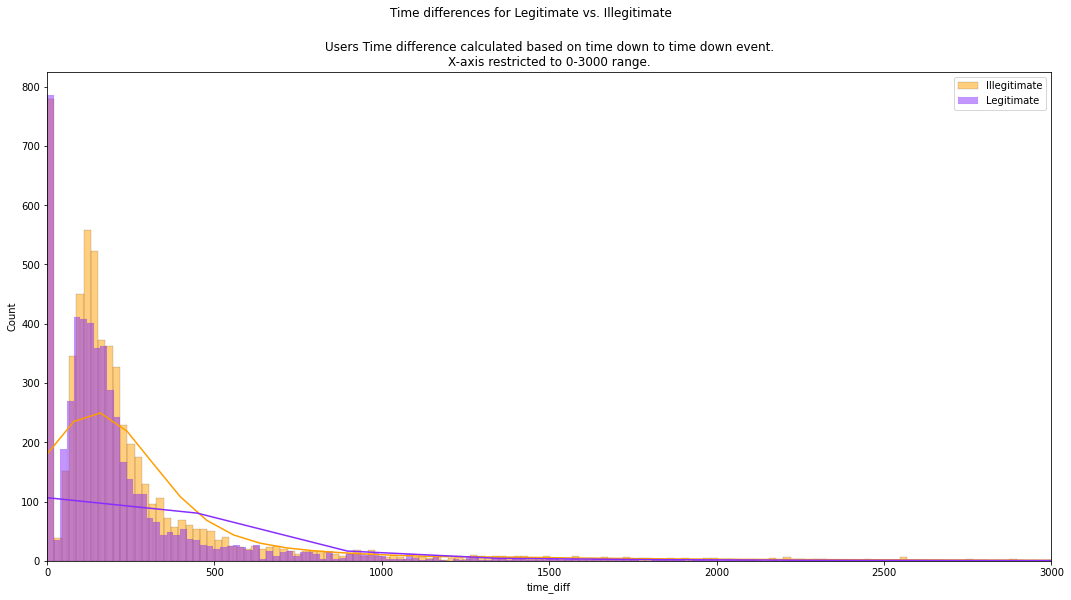

In [86]:
sns.histplot(data=df.loc[df['legit'] == False], x="time_diff", color=ms_orange, label="Illegitimate", kde=True)
sns.histplot(data=df.loc[df['legit'] == True], x="time_diff", color=ms_purple, label="Legitimate", kde=True)


plt.legend() 
plt.suptitle('Time differences for Legitimate vs. Illegitimate ')
plt.title('Users Time difference calculated based on time down to time down event.\nX-axis restricted to 0-3000 range.')
plt.xlim([0,3000])
plt.rcParams["figure.figsize"] = (18, 9)
plt.show()

## Are there patterns around Special Key usage frequency between Legitimate and Illegitate registrations?

Special keys are non-alphanumeric keys on keyboards that perform unique functions – such as backspace, shift, enter, escape.

When we explicitly calculate the difference for special key usage frequency for distinct users across legitimacy categories (i.e., Illegitimate vs. Legitimate), __it visually appears that there is a notable difference for backspace usage, compared to similar calculations for other special keys.__

For most users, it seems that backspace usage is notably higher in illegitimate cases when compared to legitimate cases, though this is not in of itself an absolute rule.

_Note: the plot below was prepared in R using the file located at `Rmd/reg-id-fraud-eda.Rmd`_

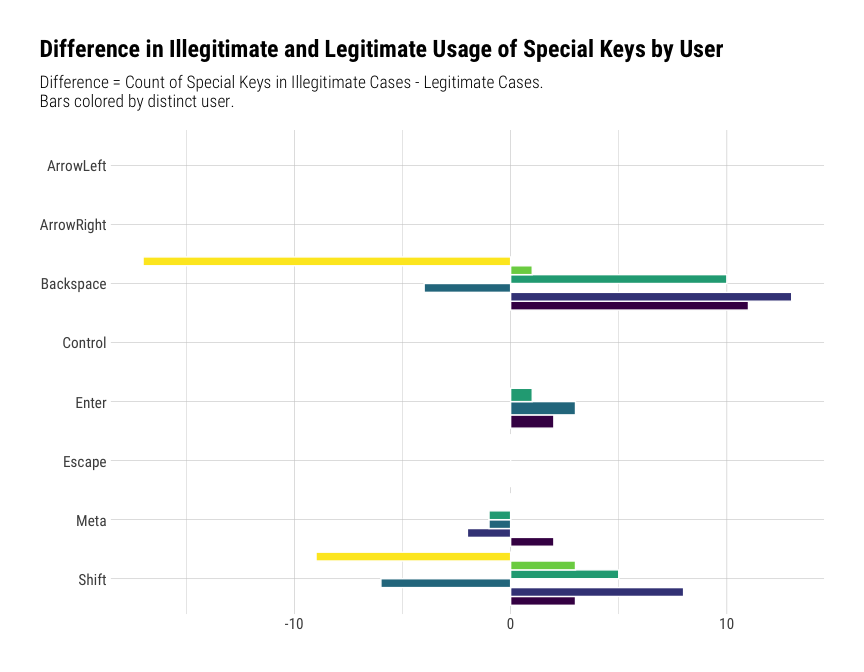

## Are there patterns around Special Key usage sequence between Legitimate and Illegitate registrations?

We can order the sequence of keys pressed within a given user journey by ordering based on the `determined_at` field.

Once we establish a sequence, we can then determine _when_ special keys get used along the course different user journeys.

_Note: the plot below was prepared in R using the file located at `Rmd/reg-id-fraud-eda.Rmd`_

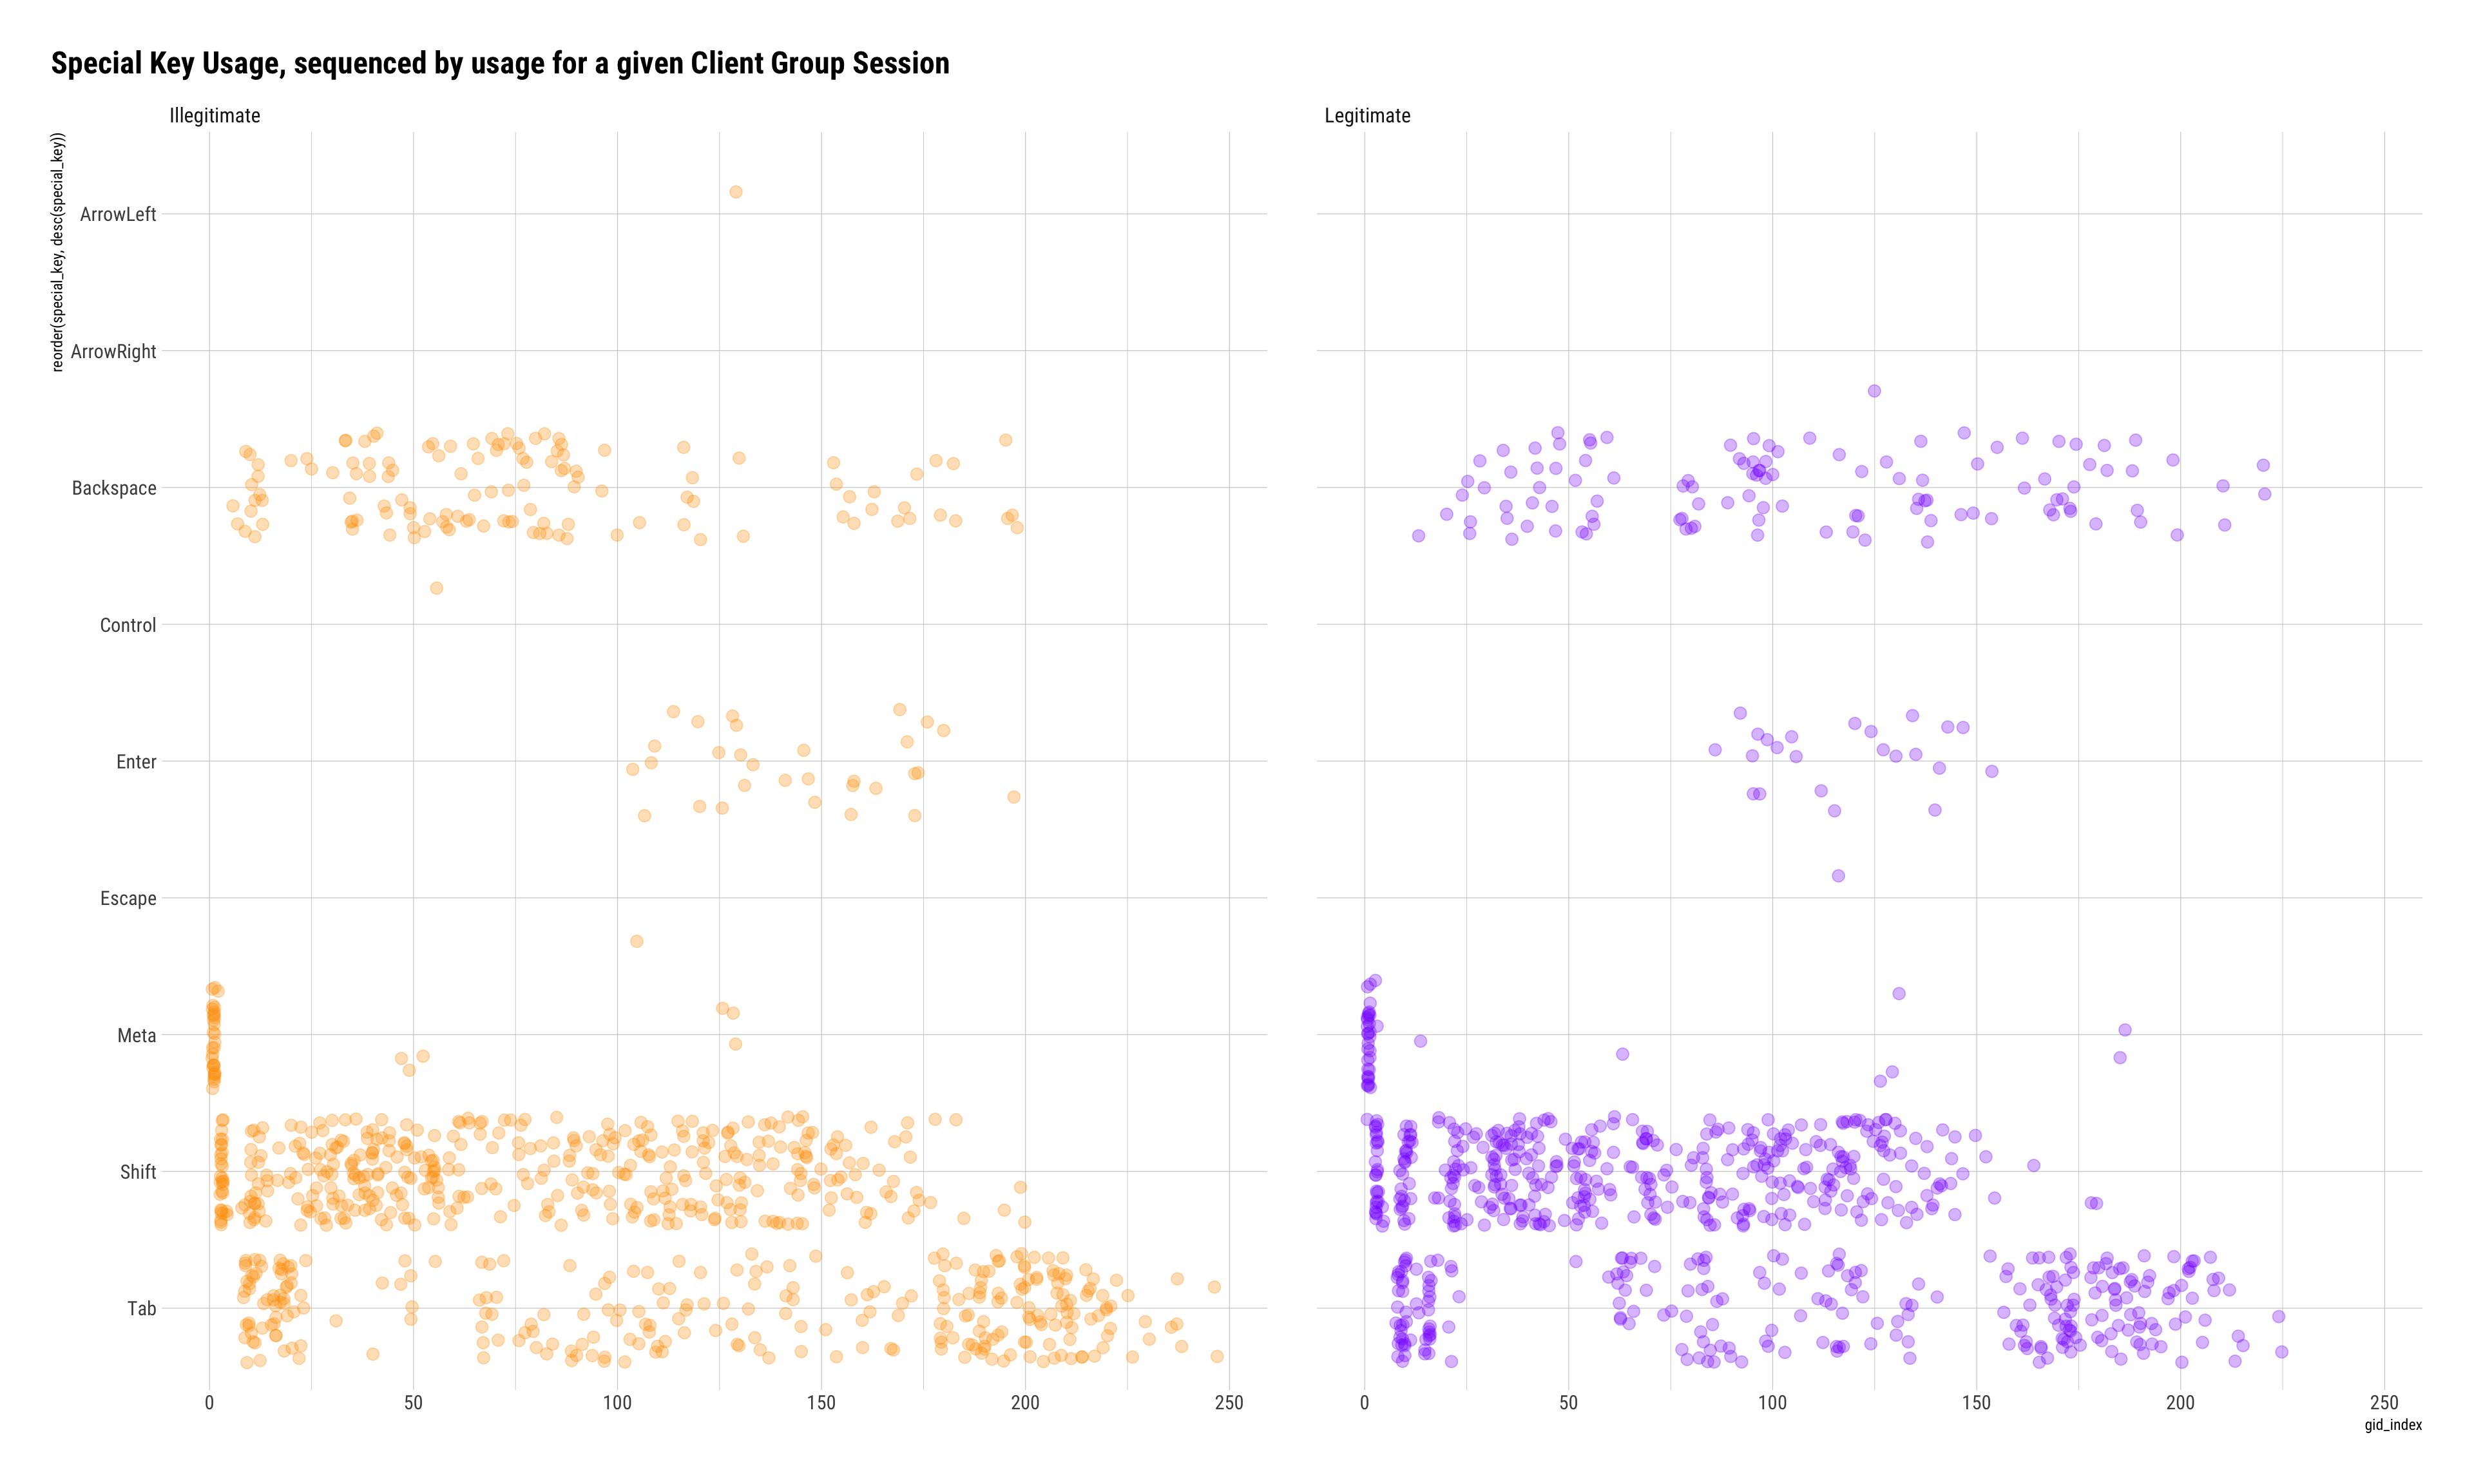

Once again, the backspace key stands out.

__It appears that the usage of the backspace tends to be more heavily clustered near the start of a user journey in illegitimate cases as compared to legitimate cases, though this is not a perfectly clean separation.__ 

We might speculate that this is due to illegitimate users being less familiar with the details to be input, which in turn might make them more prone to error as they get started with the inputs.

# Conclusion

In this demonstration, we've walked through the process of extracting Moonsense-sourced data en masse, parsing and restructuring it, and performing some preliminary exploratory analysis.

This is a process common to many data science engagements, and captures the phase of getting familiarized with the data.

The exploration has revealed a few key insights that may be useful for further anaylsis and modeling:
* There does appear to be a broad separation between legitimate and illegimate cases based on calculated time differences.
* The use of the backspace key does seem like it could be a useful discriminator.

None of the findings so far on their own will enable us to distinguish illegimate registration instances to a high degree of confidence.

We can further improve on our ability to identify illegitimate cases of registration by examining different sets of features and also by expanding the set of records examined.